<a href="https://colab.research.google.com/github/gladwel/DIP/blob/main/DAO_summarization_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [442]:
import pandas as pd

# Exploratory Data Analysis

Exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. This step is absolutely necessary and has a huge impact on the final result of a model, this analysis will tell us what type of transformation we need to apply to our data. When we face a machine learning problem, we must begin by analyzing the input dataset, seeking to identify its characteristics and anomalies.

## Read data

In [443]:
data_path = 'data/'
data_filename='proposals_06_04.csv'
output_path='data_analysis/'
# Load the data from the file system
summary = pd.read_csv(data_path+data_filename)
summary = summary[summary['middleDescription'].notna() & summary['juniorDescription'].notna() & summary['seniorDescription'].notna()]
summary.drop_duplicates(subset=["seniorDescription"],inplace=True)

summary

,id,title,daoId,juniorDescription,middleDescription,seniorDescription,startAt,endAt,author,createdAt,snapshotId,discussionLink,snapshotLink,userId,issueNumber
0,69,[ARC] Add MaticX to Polygon v3 Market,3,Stader is proposing that the Aave v3 Polygon m...,Stader is proposing that the Aave v3 Polygon m...,# Summary\r\n\r\nStader proposes addition of M...,1660510860000,1661115540000,0xc290Cfb8D020c0615e9C63036f4319Cc41717E68,1660394707282,0x88e896a245ffeda703e0b8f5494f3e66628be6e32a72...,https://governance.aave.com/t/proposal-to-add-...,https://snapshot.org/#/aave.eth/proposal/0x88e...,NaN,NaN
1,89,Should we deploy Uniswap v3 on Aurora?,2,The proposal is to deploy Uniswap v3 on Aurora...,The proposal is to deploy Uniswap v3 on Aurora...,## Summary\r\n\r\nThis proposal is created on ...,1662982755000,1663970400000,0x13BDaE8c5F0fC40231F0E6A4ad70196F59138548,1662983122731,0x2f72d9f247d9ce143809bbb4af7f5b36aa50895e517c...,https://gov.uniswap.org/t/temperature-check-un...,https://snapshot.org/#/uniswap/proposal/0x2f72...,NaN,NaN
2,29,[EP14] [Social] Dissolve Community Working Group,6,This proposal is to dissolve the Community Wor...,The proposal is to dissolve the Community Work...,This vote proposes to dissolve the Community W...,1654858800000,1655290800000,0x75cac0ceb8a39ddb4942a83ad2aafaf0c2a3e13f,1658311692253,0xa64ec8b446e509cb4b75092c4a714897790b70e2711f...,https://discuss.ens.domains/t/draft-social-dis...,https://snapshot.org/#/ens.eth/proposal/0xa64e...,NaN,29.0
3,745,Should the dYdX Community Transition from Comm...,19,This passage is proposing that the dYdX govern...,This passage is proposing that the dYdX govern...,In reference to this discussion:\r\nhttps://co...,1680230173000,1680575773000,0xccC4e8Ad313dF8150211B1b934725345924ab81D,1680144307983,0xa5e77732dd24edd26bd41b089969b3662c29eb41c3ba...,https://commonwealth.im/dydx/discussion/10584-...,https://snapshot.org/#/dydxgov.eth/proposal/0x...,NaN,684.0
4,345,[ARC] Compensate Bug Bounty Contributor,3,The proposal is to reward an individual who fo...,The proposal is to reward an individual who fo...,## Simple Summary\r\n\r\nCompensate contributo...,1674272100000,1674876900000,0xDD659911EcBD4458db07Ee7cDdeC79bf8F859AbC,1674186308534,0x4f97f52ef593bbdddc1037597729e1575ed8d4df997c...,https://governance.aave.com/t/arc-compensate-b...,https://snapshot.org/#/aave.eth/proposal/0x4f9...,NaN,280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,789,[AGIP 73] Liquidity Provision: Adding the $2.5...,29,This text is a proposal to the directors of th...,This text is a proposal to the directors of th...,**Author:** Maxicrouton#1596\r\n**Gotchi ID:**...,1680717344000,1681322100000,0xb8B95A513C2F754AE61087edfe0057c80513e649,1680717607218,0x9d2a5cbe986c1c1f30132c3e396470e6b67f7d74ce2a...,https://dao.aavegotchi.com/t/where-should-25-l...,https://snapshot.org/#/aavegotchi.eth/proposal...,NaN,737.0
699,791,[AGIP 72] Liquidity Provision: Reimbursement o...,29,This proposal is about using $5 million of DAI...,This proposal is about using $5 million of DAI...,**Author:** Maxicrouton#1596\r\n**Gotchi ID:**...,1680717147000,1681321920000,0xb8B95A513C2F754AE61087edfe0057c80513e649,1680717607284,0x7fe819f1bba47d2322d4bb1f1b796a3a13c96146ac90...,https://dao.aavegotchi.com/t/where-should-25-l...,https://snapshot.org/#/aavegotchi.eth/proposal...,NaN,736.0
700,807,[BIP-240] Enable rETH/bb-a-wETH Gauge [Arbitrum],12,This proposal is for a new pool on Arbitrum cr...,This proposal is for a new pool on Arbitrum cr...,https://github.com/BalancerMaxis/multisig-ops/...,1680796800000,1681142400000,0x512fce9B07Ce64590849115EE6B32fd40eC0f5F3,1680776108847,0xc9b885108fe8ddc26109e1a2626d5b90b7a52883b894...,https://forum.balancer.fi/t/bip-240-enable-ret...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,798.0
701,808,[BIP-241] Aave v3 Migration,12,This proposal is about transitioning from the ...,This proposal is about transitioning from the ...,https://github.com/BalancerMaxis/multisig-ops/.

In [444]:
# rows with seniorDescription length less than 200
summary['seniorLength'] = summary['seniorDescription'].str.len().astype(int)
summary['middleLength'] = summary['middleDescription'].str.len().astype(int)
summary['juniorLength'] = summary['juniorDescription'].str.len().astype(int)

summary[summary['seniorLength'] <= 200]

,id,title,daoId,juniorDescription,middleDescription,seniorDescription,startAt,endAt,author,createdAt,snapshotId,discussionLink,snapshotLink,userId,issueNumber,seniorLength,middleLength,juniorLength
55,40,"Temp Check: ""Fee switch"" activation for ETH/US...",2,The proposal is about designing a fee switch f...,The proposal is about designing a fee switch f...,See governance forum for details: https://gov....,1658184092000,1658412000000,0x067b9Bbbbc42d2AB9b9Ab6bB62646dAF7F344A76,1659342474755,0x4dd49ee723a7e506c6c6c15c8eabc8a7057f3f0760e4...,https://gov.uniswap.org/t/fee-switch-design-sp...,https://snapshot.org/#/uniswap/proposal/0x4dd4...,NaN,40.0,100,108,108
84,68,[Consensus Check] Create the Uniswap Foundation,2,The passage is about a proposal to create the ...,The passage is about a proposal to create the ...,Read the full proposal here: https://gov.unisw...,1660138758000,1660572000000,0xf665F2eD351696817898fe0Ace20c5C1Bc3c5796,1660139104117,0xd70b3e84db501c2633bc8189fcfc335726fce90584a3...,https://gov.uniswap.org/t/consensus-check-crea...,https://snapshot.org/#/uniswap/proposal/0xd70b...,NaN,68.0,106,217,217
103,118,Optimism-Uniswap Protocol LM Program: Pool sel...,2,1. The first proposal is to select the WETH/US...,1. The first proposal is to select the WETH/US...,Which pools should be selected?\r\n\r\n1. WETH...,1665747505000,1666008000000,0xf665F2eD351696817898fe0Ace20c5C1Bc3c5796,1665748804788,0x255d43357e17858f8664ffaaeaf7660bfd8be5f7dabc...,https://gov.uniswap.org/t/rfc-the-optimism-uni...,https://snapshot.org/#/uniswap/proposal/0x255d...,NaN,91.0,124,230,230
138,44,"[Consensus Check] ""Fee switch"" Pilot for Three...",2,The passage is about a proposal to test out a ...,The passage is about a proposal to test out a ...,See governance forum for details: https://gov....,1659639419000,1660075200000,0x067b9Bbbbc42d2AB9b9Ab6bB62646dAF7F344A76,1659639610081,0xe9f8e5dd7ec26f7c0e7dd9e19bb8d57497d27d4a74be...,https://gov.uniswap.org/t/consensus-check-fee-...,https://snapshot.org/#/uniswap/proposal/0xe9f8...,NaN,44.0,98,522,522
150,269,Execution of the proposal: Purchase $OPIUM Opt...,8,The proposal is about creating a pool of money...,The proposal is about creating a pool of money...,Execution of the proposal: Purchase $OPIUM Opt...,1671433200000,1671606000000,0x84E94F8032b3F9fEc34EE05F192Ad57003337988,1671440408850,0xc80a960b9c07f7f3e26c6f550db90fa52bd4e76ac01c...,https://forum.opium.network/t/proposal-run-liq...,https://snapshot.org/#/opiumprotocol.eth/propo...,NaN,207.0,154,421,421


In [445]:
# delete rows with seniorDescription length less than 200
summary = summary[summary['seniorLength'] > 200]

In [446]:
summary

,id,title,daoId,juniorDescription,middleDescription,seniorDescription,startAt,endAt,author,createdAt,snapshotId,discussionLink,snapshotLink,userId,issueNumber,seniorLength,middleLength,juniorLength
0,69,[ARC] Add MaticX to Polygon v3 Market,3,Stader is proposing that the Aave v3 Polygon m...,Stader is proposing that the Aave v3 Polygon m...,# Summary\r\n\r\nStader proposes addition of M...,1660510860000,1661115540000,0xc290Cfb8D020c0615e9C63036f4319Cc41717E68,1660394707282,0x88e896a245ffeda703e0b8f5494f3e66628be6e32a72...,https://governance.aave.com/t/proposal-to-add-...,https://snapshot.org/#/aave.eth/proposal/0x88e...,NaN,NaN,8467,320,320
1,89,Should we deploy Uniswap v3 on Aurora?,2,The proposal is to deploy Uniswap v3 on Aurora...,The proposal is to deploy Uniswap v3 on Aurora...,## Summary\r\n\r\nThis proposal is created on ...,1662982755000,1663970400000,0x13BDaE8c5F0fC40231F0E6A4ad70196F59138548,1662983122731,0x2f72d9f247d9ce143809bbb4af7f5b36aa50895e517c...,https://gov.uniswap.org/t/temperature-check-un...,https://snapshot.org/#/uniswap/proposal/0x2f72...,NaN,NaN,10681,338,338
2,29,[EP14] [Social] Dissolve Community Working Group,6,This proposal is to dissolve the Community Wor...,The proposal is to dissolve the Community Work...,This vote proposes to dissolve the Community W...,1654858800000,1655290800000,0x75cac0ceb8a39ddb4942a83ad2aafaf0c2a3e13f,1658311692253,0xa64ec8b446e509cb4b75092c4a714897790b70e2711f...,https://discuss.ens.domains/t/draft-social-dis...,https://snapshot.org/#/ens.eth/proposal/0xa64e...,NaN,29.0,3802,758,205
3,745,Should the dYdX Community Transition from Comm...,19,This passage is proposing that the dYdX govern...,This passage is proposing that the dYdX govern...,In reference to this discussion:\r\nhttps://co...,1680230173000,1680575773000,0xccC4e8Ad313dF8150211B1b934725345924ab81D,1680144307983,0xa5e77732dd24edd26bd41b089969b3662c29eb41c3ba...,https://commonwealth.im/dydx/discussion/10584-...,https://snapshot.org/#/dydxgov.eth/proposal/0x...,NaN,684.0,1977,568,568
4,345,[ARC] Compensate Bug Bounty Contributor,3,The proposal is to reward an individual who fo...,The proposal is to reward an individual who fo...,## Simple Summary\r\n\r\nCompensate contributo...,1674272100000,1674876900000,0xDD659911EcBD4458db07Ee7cDdeC79bf8F859AbC,1674186308534,0x4f97f52ef593bbdddc1037597729e1575ed8d4df997c...,https://governance.aave.com/t/arc-compensate-b...,https://snapshot.org/#/aave.eth/proposal/0x4f9...,NaN,280.0,1036,261,261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,789,[AGIP 73] Liquidity Provision: Adding the $2.5...,29,This text is a proposal to the directors of th...,This text is a proposal to the directors of th...,**Author:** Maxicrouton#1596\r\n**Gotchi ID:**...,1680717344000,1681322100000,0xb8B95A513C2F754AE61087edfe0057c80513e649,1680717607218,0x9d2a5cbe986c1c1f30132c3e396470e6b67f7d74ce2a...,https://dao.aavegotchi.com/t/where-should-25-l...,https://snapshot.org/#/aavegotchi.eth/proposal...,NaN,737.0,1619,662,662
699,791,[AGIP 72] Liquidity Provision: Reimbursement o...,29,This proposal is about using $5 million of DAI...,This proposal is about using $5 million of DAI...,**Author:** Maxicrouton#1596\r\n**Gotchi ID:**...,1680717147000,1681321920000,0xb8B95A513C2F754AE61087edfe0057c80513e649,1680717607284,0x7fe819f1bba47d2322d4bb1f1b796a3a13c96146ac90...,https://dao.aavegotchi.com/t/where-should-25-l...,https://snapshot.org/#/aavegotchi.eth/proposal...,NaN,736.0,2168,731,731
700,807,[BIP-240] Enable rETH/bb-a-wETH Gauge [Arbitrum],12,This proposal is for a new pool on Arbitrum cr...,This proposal is for a new pool on Arbitrum cr...,https://github.com/BalancerMaxis/multisig-ops/...,1680796800000,1681142400000,0x512fce9B07Ce64590849115EE6B32fd40eC0f5F3,1680776108847,0xc9b885108fe8ddc26109e1a2626d5b90b7a52883b894...,https://forum.balancer.fi/t/bip-240-enable-ret...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,798.0,4490,735,735
701,808,[BIP-241] Aave v3 Migr

In [447]:
# sort summary by id
summary = summary.sort_values(by=['id'])
summary

,id,title,daoId,juniorDescription,middleDescription,seniorDescription,startAt,endAt,author,createdAt,snapshotId,discussionLink,snapshotLink,userId,issueNumber,seniorLength,middleLength,juniorLength
390,1,[1IP-07] Integrate Balancer Boosted Pools in t...,1,The proposal is about integrating Balancer Boo...,This proposal calls for the integration of Bal...,## Simple Summary\r\n\r\nThis proposal calls f...,1651554223000,1652159023000,0x824732d3f4eb94a20254cca9de10485ce445bb40,1657200979740,0x6358c27cd2d5a95e58095e5cc3b1b9a85d2c9af2a363...,https://gov.1inch.io/t/1ip-07-integrate-balanc...,https://snapshot.org/#/1inch.eth/proposal/0x63...,NaN,1.0,4641,320,290
25,2,[1IP-06] Donation of 1inch DAO Treasury Funds ...,1,The 1inch DAO Treasury is proposing to donate ...,The 1inch DAO is proposing to donate 1 million...,## Summary\r\n\r\n1inch Network was founded on...,1646760014000,1647364814000,0x824732d3f4eb94a20254cca9de10485ce445bb40,1657200981507,0xf4f712189924944dfd1cb438dc3235f4f4d5493f8c9d...,NaN,https://snapshot.org/#/1inch.eth/proposal/0xf4...,NaN,2.0,2997,365,302
317,3,[Temperature Check] Should the Uniswap communi...,2,The Protocol Guild is a council of Ethereum pr...,"The authors are proposing that 500,000 UNI (ab...",Authors: [Trent](https://twitter.com/trent_van...,1654176425000,1654437600000,0x4c0a466df0628fe8699051b3ac6506653191cc21,1657200982022,0x7f196c3444623a33ac147d1676d84e45d3c4c56a94ba...,https://gov.uniswap.org/t/temperature-check-sh...,https://snapshot.org/#/uniswap/proposal/0x7f19...,NaN,3.0,8717,504,330
388,4,Aave V3 Harmony - Freeze Reserves,3,The proposal is about freezing all reserves on...,"The Aave DAO Community, through the governance...",title: Aave V3 Harmony - Freeze Reserves\r\nst...,1657807792000,1658138400000,0xd2362dbb5aa708bc454ce5c3f11050c016764fa6,1658239945117,0x81a78109941e5e0ac6cb5ebf82597c839c20ad6821a8...,https://governance.aave.com/t/aave-v3-harmony-...,https://snapshot.org/#/aave.eth/proposal/0x81a...,NaN,4.0,1691,879,275
209,5,Revised ARC: Add 1INCH as collateral,3,The proposal seeks to add 1inch Network's 1INC...,1inch Network is a decentralized set of protoc...,# Summary\r\n1inch is a network of decentraliz...,1657638000000,1657983600000,0xc290cfb8d020c0615e9c63036f4319cc41717e68,1658239945766,0x2ea76814a0dfcad7ea1a7b3c597f059a8d574f814388...,https://governance.aave.com/t/arc-add-1inch-as...,https://snapshot.org/#/aave.eth/proposal/0x2ea...,NaN,5.0,12234,745,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,805,[BIP-237] Enable USH - ETH 50/50 Gauge with 10...,12,This proposal is about adding a gauge to the n...,This proposal is about adding a gauge to the n...,[PR with Payload](https://github.com/BalancerM...,1680796800000,1681142400000,0x9f74662aD05840Ba35d111930501c617920dD68e,1680720307179,0x495c40b72c0bc24173c4ebdfb7ac3986bd3978fcae20...,https://forum.balancer.fi/t/bip-237-enable-ush...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,783.0,8322,731,731
695,806,[BIP-239] Enable bb-a-USD gauge [Ethereum],12,This passage is describing a proposal to add a...,This passage is describing a proposal to add a...,[PR with Payload](https://github.com/BalancerM...,1680796800000,1681142400000,0x9f74662aD05840Ba35d111930501c617920dD68e,1680720307225,0x7e2f179b46a590b28d8f2d6641db8ccad415a152a558...,https://forum.balancer.fi/t/bip-239-enable-bb-...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,795.0,1861,561,561
700,807,[BIP-240] Enable rETH/bb-a-wETH Gauge [Arbitrum],12,This proposal is for a new pool on Arbitrum cr...,This proposal is for a new pool on Arbitrum cr...,https://github.com/BalancerMaxis/multisig-ops/...,1680796800000,1681142400000,0x512fce9B07Ce64590849115EE6B32fd40eC0f5F3,1680776108847,0xc9b885108fe8ddc26109e1a2626d5b90b7a52883b894...,https://forum.balancer.fi/t/bip-240-enable-ret...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,798.0,4490,735,735
701,808,[BIP-241] Aave v3 Migration,12,This proposal is about transitioning fr

In [448]:
summary.iloc[5][['middleDescription', 'juniorDescription']].tolist()

['agEUR is a € stablecoin with a supply of 48.7m, a TVL in the protocol of $87m, and an average daily volume > $4m. It can be minted at oracle value meaning liquidity for it could be theoretically infinite.\r\nThe stablecoin is over-collateralized (current collateral ratio = 180%), it is backed by USDC, DAI, FEI and FRAX. The protocol has also launched a new module that allows people to borrow agEUR against wETH, wstETH and wBTC.\r\nagEUR is already supported in efficiency mode with other stablecoins which should technically allow people to take leverage on Forex, or to arb more easily stablecoins at peg. Doing this in isolation mode would mean this asset would induce very small risk for the Aave protocol as a whole.\r\n\r\nI propose the following risk parameter linked to the isolation mode: V3 Isolation mode: 60% LTV, 80% liquidation threshold, 20% reserve factor, 3M$ debt ceiling.',
 'The proposal is to allow agEUR to be used as a collateral in isolation mode on AAVE V3 on Polygon. T

In [449]:
summary.iloc[1][['seniorDescription', 'middleDescription', 'juniorDescription', 'snapshotLink', 'discussionLink']].tolist()

['## Summary\r\n\r\n1inch Network was founded on core values of decentralization and open financial freedom, with a goal of improving the human condition for everyone on the planet. As one of the leading dApps in the DeFi space, it is in a unique position to extend additional assistance to people in a time of need.\r\n\r\nWith that said, this proposal seeks to donate 1 million USDC of 1inch DAO Treasury funds to support humanitarian aid within the country of Ukraine.\r\n\r\n## Abstract\r\n\r\nSince inception just over 3 months ago, the 1inch DAO Treasury has been highly successful in growing its total capital. It has accumulated close to 7 million USDC to date from a steady income stream of swap surplus funds. This proposal aims to donate 1 million USDC of these accumulated funds to provide critical humanitarian support within Ukraine’s conflict zone.\r\n\r\nSpecifically, these funds will be converted into USDT via 1inch v4 protocol, then transferred to the official wallet of Ukraine, 

In [450]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [451]:
summary = summary[['seniorDescription', 'middleDescription', 'juniorDescription', 'seniorLength', 'middleLength', 'juniorLength']]

## Exploring relevant features in the data

In [452]:
summary

,seniorDescription,middleDescription,juniorDescription,seniorLength,middleLength,juniorLength
390,## Simple Summary\r\n\r\nThis proposal calls f...,This proposal calls for the integration of Bal...,The proposal is about integrating Balancer Boo...,4641,320,290
25,## Summary\r\n\r\n1inch Network was founded on...,The 1inch DAO is proposing to donate 1 million...,The 1inch DAO Treasury is proposing to donate ...,2997,365,302
317,Authors: [Trent](https://twitter.com/trent_van...,"The authors are proposing that 500,000 UNI (ab...",The Protocol Guild is a council of Ethereum pr...,8717,504,330
388,title: Aave V3 Harmony - Freeze Reserves\r\nst...,"The Aave DAO Community, through the governance...",The proposal is about freezing all reserves on...,1691,879,275
209,# Summary\r\n1inch is a network of decentraliz...,1inch Network is a decentralized set of protoc...,The proposal seeks to add 1inch Network's 1INC...,12234,745,255
...,...,...,...,...,...,...
667,[PR with Payload](https://github.com/BalancerM...,This proposal is about adding a gauge to the n...,This proposal is about adding a gauge to the n...,8322,731,731
695,[PR with Payload](https://github.com/BalancerM...,This passage is describing a proposal to add a...,This passage is describing a proposal to add a...,1861,561,561
700,https://github.com/BalancerMaxis/multisig-ops/...,This proposal is for a new pool on Arbitrum cr...,This proposal is for a new pool on Arbitrum cr...,4490,735,735
701,https://github.com/BalancerMaxis/multisig-ops/...,This proposal is about transitioning from the ...,This proposal is about transitioning from the ...,5229,523,523


In [453]:
summary.describe()

,seniorLength,middleLength,juniorLength
count,686.000000,686.000000,686.000000
mean,3956.224490,538.357143,528.674927
std,3210.126446,202.278653,204.207632
min,250.000000,20.000000,20.000000
25%,1568.250000,402.000000,388.000000
50%,3084.000000,531.500000,527.000000
75%,5115.500000,662.750000,653.000000
max,14583.000000,1201.000000,1201.000000


### Statistical Count Features from headlines and text that we are going to explore

In [454]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
import re, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [455]:
# Storing the sets of punctuation in variable result
punc = string.punctuation
stopwords = set(stopwords.words('english'))
print(punc)
print(stopwords)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
{'both', 'or', 'y', 'needn', 'won', 'having', "couldn't", 'll', 'my', 'will', 'no', "shouldn't", "wasn't", 'under', 'most', 'shan', 'his', 'just', 'any', 'before', 'below', "isn't", 'mightn', 'yourselves', 'these', 'into', 'not', 'the', 'few', "haven't", "didn't", 'once', 'did', 'how', 'above', "mightn't", 'again', 'by', 'after', 'in', "you'll", 'ourselves', 'be', 'and', 'didn', 'further', 'than', 'ours', 'through', 'had', 'do', 'all', 'now', 'that', 'd', 'is', 'being', 'own', 'hadn', 'been', "should've", 'doesn', 'what', 'some', "doesn't", 'an', 'where', 'their', 'very', "hadn't", 'your', 's', 'mustn', "won't", "don't", 'those', 'then', 've', 'they', 'because', 'her', "you'd", 'it', 'if', 'until', 'but', 'same', 'herself', 'as', "shan't", 'at', "that'll", 'isn', 'here', 'our', 'himself', 'doing', "it's", 'ma', 'down', 'between', "wouldn't", 'with', 'aren', 'nor', 'other', 'myself', 'i', 'more', 'on', 'don', 'are', "weren't", 'theirs', "you're", 't', 'w

In [456]:
# A function to count stopwords in a dataframe column
def count_stopwords(text, stopwords):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    word_tokens = word_tokenize(text) #splitta i pezzi
    stopwords_x = [w for w in word_tokens if w in stopwords]

    return len(stopwords_x)

In [457]:
# Create a new variable containing the number of sentences in the summary
summary['sum_sent_count'] = summary['juniorDescription'].apply(lambda x : len(sent_tokenize(x)))
# Create a new variable containing the number of sentences in the text
# TODO fix sentence amount problems (example id=396)
summary['text_sent_count'] = summary['seniorDescription'].apply(lambda x : len(sent_tokenize(x)))
# # Create a new variable containing the number of word in the summary
summary['sum_word_count'] = summary['juniorDescription'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of word in the text
summary['text_word_count'] = summary['seniorDescription'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of characters in the summary
summary['sum_char_count'] = summary['juniorDescription'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the number of characters in the text
summary['text_char_count'] = summary['seniorDescription'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the density of words in the summary
summary['sum_word_density'] = summary['sum_word_count'] / (summary['sum_char_count'] + 1)
# Create a new variable containing the density of words in the text
summary['text_word_density'] = summary['text_word_count'] / (summary['text_char_count'] + 1)
# Create a new variable containing the density of sentences in the summary
summary['sum_sent_density'] = summary['sum_sent_count'] / (summary['sum_word_count'] + 1)
# Create a new variable containing the density of sentences in the text
summary['text_sent_density'] = summary['text_sent_count'] / (summary['text_word_count'] + 1)
# Create a new variable containing the number of punctuations in the summary
summary['sum_punc_count'] = summary['juniorDescription'].apply(lambda x : len([a for a in x if a in punc]))
# Create a new variable containing the number of punctuations in the text
summary['text_punc_count'] = summary['seniorDescription'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords
# Create a new variable containing the number of stopwords in the text
summary['text_stopw_count'] =  summary['seniorDescription'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the number of stopwords in the summary
summary['sum_stopw_count'] =  summary['juniorDescription'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the density of stopwords in the summary
summary['sum_stopw_density'] = summary['sum_stopw_count'] / (summary['sum_word_count'] + 1)
# Create a new variable containing the density of stopwords in the text
summary['text_stopw_density'] = summary['text_stopw_count'] / (summary['text_word_count'] + 1)

summary.describe()

,seniorLength,middleLength,juniorLength,sum_sent_count,text_sent_count,sum_word_count,text_word_count,sum_char_count,text_char_count,sum_word_density,text_word_density,sum_sent_density,text_sent_density,sum_punc_count,text_punc_count,text_stopw_count,sum_stopw_count,sum_stopw_density,text_stopw_density
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,3956.224490,538.357143,528.674927,3.626822,23.781341,85.504373,540.969388,444.179300,3417.029155,0.194262,0.159082,0.043662,0.044957,11.272595,205.030612,184.177843,32.432945,0.375965,0.330505
std,3210.126446,202.278653,204.207632,1.221741,20.553054,31.706857,456.847564,172.972657,2738.484260,0.014992,0.028462,0.010825,0.013572,6.048228,191.867055,169.427298,12.219072,0.047609,0.057226
min,250.000000,20.000000,20.000000,1.000000,1.000000,4.000000,39.000000,17.000000,205.000000,0.138655,0.036341,0.020833,0.008343,0.000000,8.000000,6.000000,2.000000,0.166667,0.106383
25%,1568.250000,402.000000,388.000000,3.000000,9.000000,63.000000,216.250000,325.000000,1341.250000,0.184545,0.140840,0.037594,0.037072,7.000000,67.000000,72.250000,24.000000,0.347010,0.295402
50%,3084.000000,531.500000,527.000000,4.000000,18.000000,85.500000,410.000000,443.000000,2683.500000,0.193852,0.164665,0.042553,0.043548,10.000000,143.000000,136.000000,32.000000,0.373626,0.336445
75%,5115.500000,662.750000,653.000000,4.000000,31.000000,105.000000,690.500000,550.250000,4435.750000,0.202275,0.179945,0.048387,0.050965,14.000000,280.500000,217.000000,40.000000,0.407127,0.367855
max,14583.000000,1201.000000,1201.000000,9.000000,138.000000,187.000000,2242.000000,1015.000000,12560.000000,0.248521,0.237864,0.200000,0.104167,47.000000,1432.000000,948.000000,75.000000,0.529412,0.469231


### Analyze the feature distributions

In [458]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

In [459]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figesize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - labels: a dictionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''

   # We need to identify is this a matrix or a vector
    if plot_vars.ndim == 1:
        nrows=1
        ncols = plot_vars.shape[0]
    else:
        nrows= plot_vars.shape[0]
        ncols = plot_vars.shape[1]

    #Create a figure and its axes for the dimensions defined
    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(15,5))
    #For every variable in the plot_vars
    for i in range(nrows):
        for j in range(ncols):
            # If the column name is defined we plot it
            if plot_vars[i,j]!=None:
                if axes.ndim>1:
                    #Set the title
                    axes[i,j].set_title(labels[plot_vars[i,j]])
                    axes[i,j].grid(True)
                    #Set x ticks
                    axes[i,j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[i,j].boxplot(data[plot_vars[i,j]])
                else:
                    #Set the title
                    axes[j].set_title(labels[plot_vars[i,j]])
                    axes[j].grid(True)
                    #Set x ticks
                    axes[j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[j].boxplot(data[plot_vars[i,j]])

            else:
                axes[i,j].set_visible(False)
    # Adjust the plots for a better visualization
    f.tight_layout()
    plt.show()


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_histograms(data, plot_vars, xlim, labels, figsize):
    ''' Function to plot the histograms of the variables in plot_vars
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - xlim: a list, define the max x value for every column to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    #Set some parameters
    kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})

    #cmap = get_cmap(plot_vars.shape[1])
    # Create the figure and axes
    fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)
    #For every variable in plot_vars
    for i in range(plot_vars.shape[1]):
        # Plot the histogram
        sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),),
                     ax=axes[i], axlabel=labels[plot_vars[0,i]], bins= 50, norm_hist = True)
        #For a better visualization we set the x limit
        axes[i].set_xlim(left=0, right=xlim[i])

    fig.tight_layout()

ratio = 0.5
fig_size = (10/ratio, 3/ratio)
print('fig_size = {}'.format(fig_size))

fig_size = (20.0, 6.0)


#### Analyze the feature distributions on the seniorDescription variable

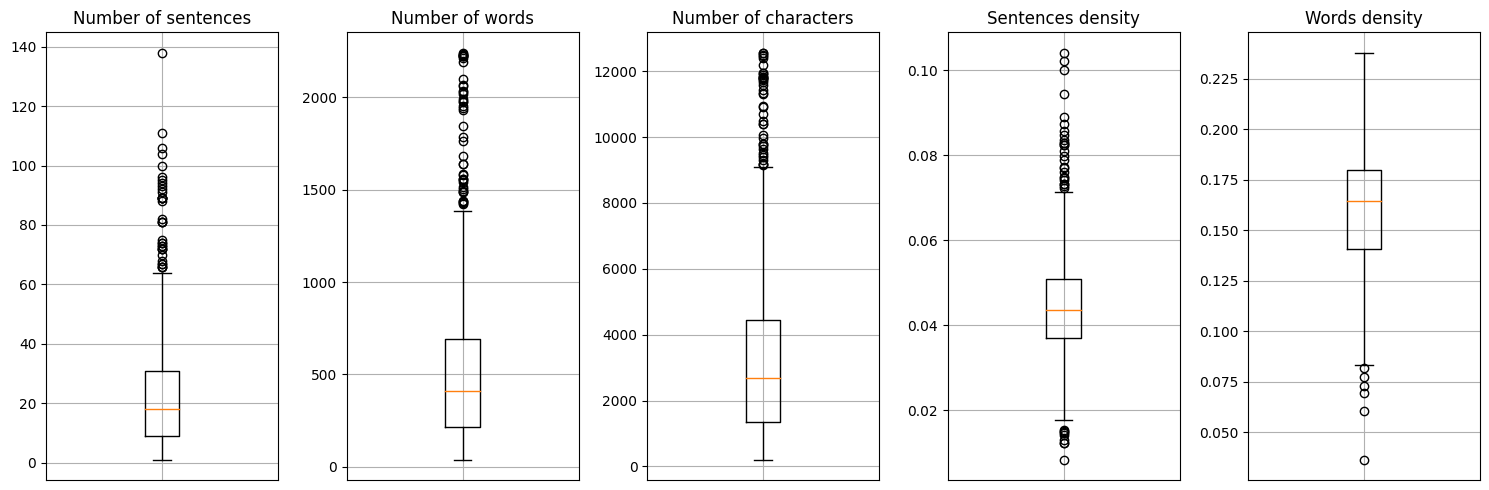

C:\Users\Herman\AppData\Local\Temp\ipykernel_36692\2254158654.py:82: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),),
C:\Users\Herman\AppData\Local\Temp\ipykernel_36692\2254158654.py:82: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457a

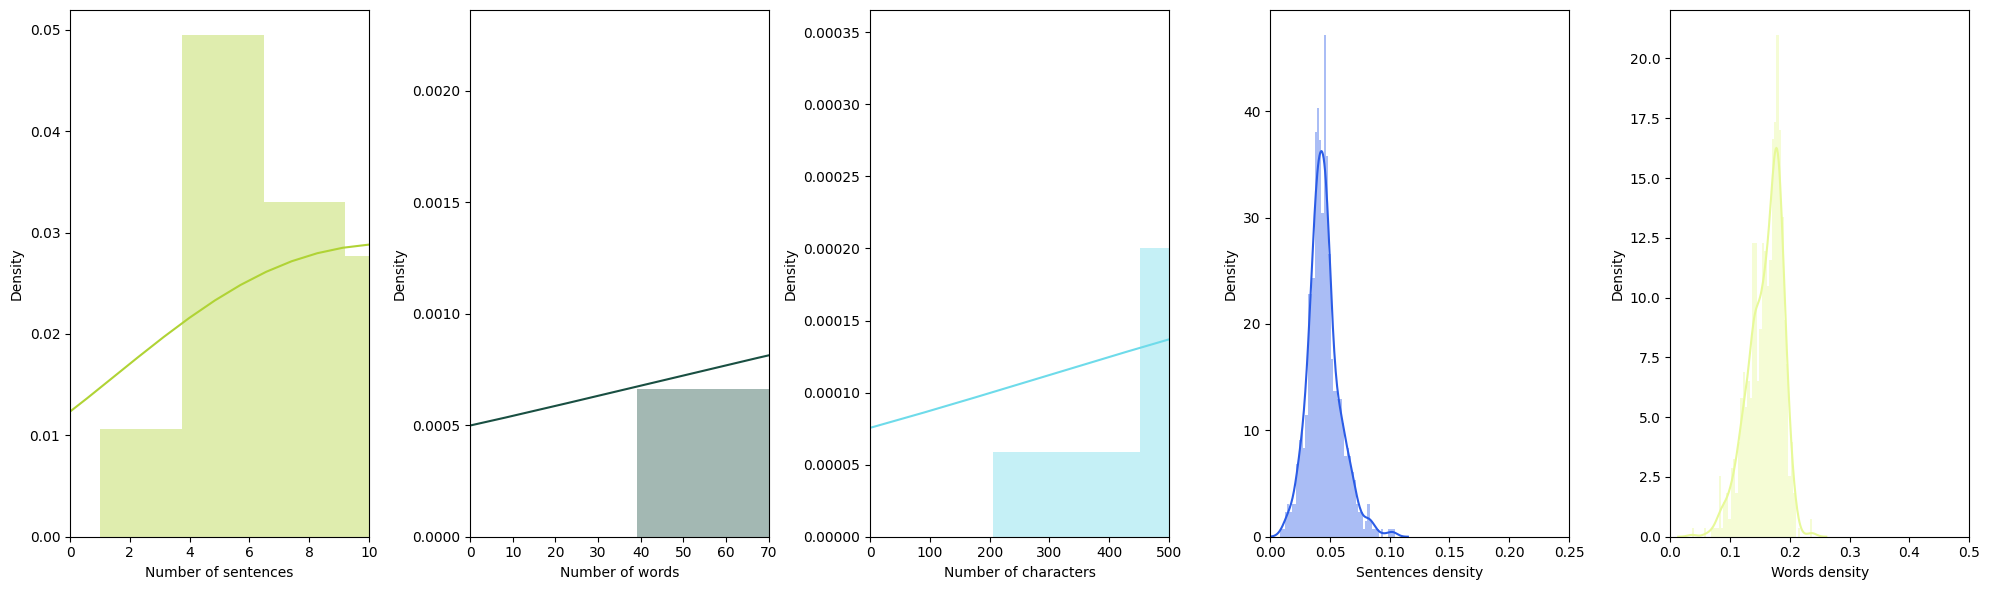

In [460]:
#Set the columns to plot
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
# Plot the boxplots for the interesting columns
labels_dict = {'text_sent_count':'Number of sentences', 'text_word_count':'Number of words',
               'text_char_count':'Number of characters', 'text_sent_density':'Sentences density',
               'text_word_density':'Words density'}
plot_boxplots(summary, plot_vars, labels_dict, figsize=fig_size)
# Plot the histograms
plot_histograms(summary, plot_vars, [10, 70, 500, 0.25, 0.5], labels_dict, figsize=fig_size)

#### Analyze the feature distributions on the juniorDescription variable

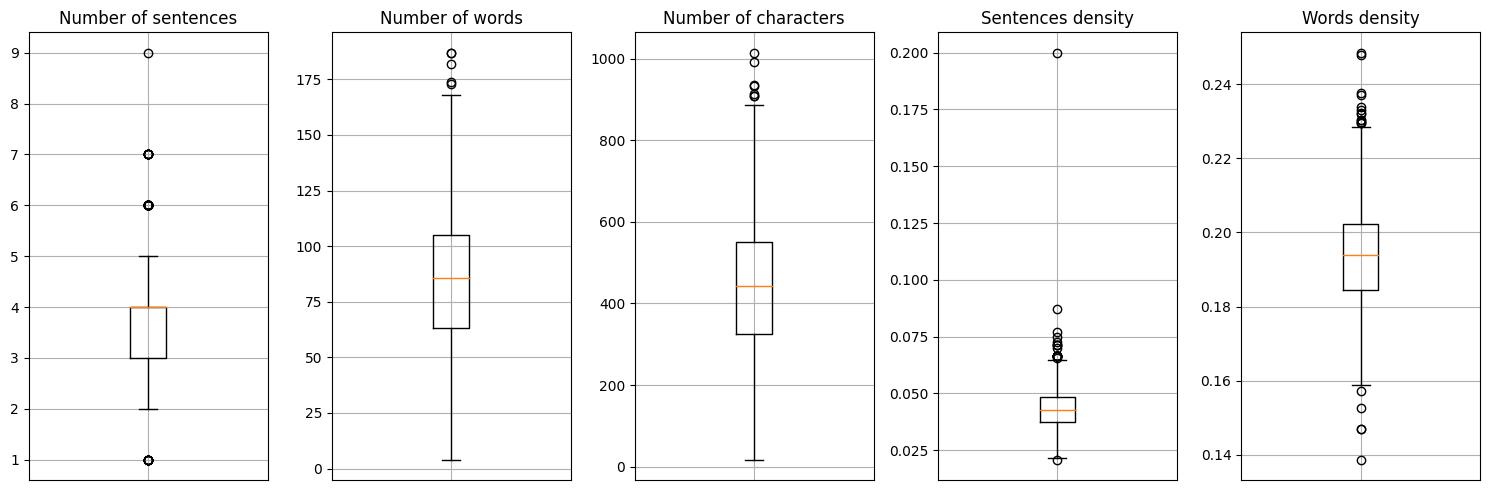

C:\Users\Herman\AppData\Local\Temp\ipykernel_36692\2254158654.py:82: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),),
C:\Users\Herman\AppData\Local\Temp\ipykernel_36692\2254158654.py:82: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457a

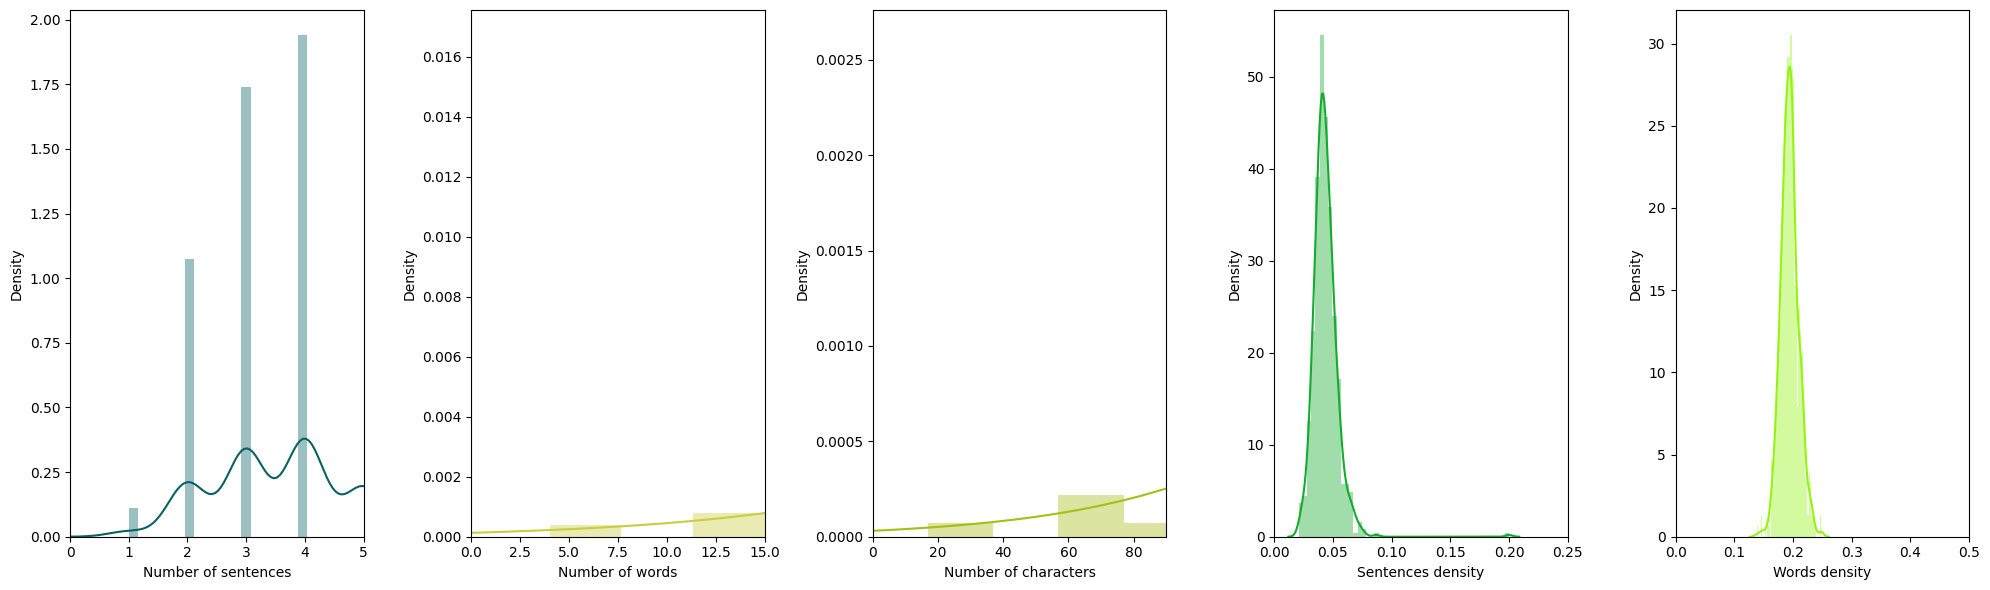

In [461]:
plot_vars=np.array([['sum_sent_count', 'sum_word_count', 'sum_char_count','sum_sent_density','sum_word_density']])
labels_dict = {'sum_sent_count':'Number of sentences', 'sum_word_count':'Number of words',
               'sum_char_count':'Number of characters', 'sum_sent_density':'Sentences density',
               'sum_word_density':'Words density'}
# Plot the boxplots and histograms for the interesting columns
plot_boxplots(summary, plot_vars, labels_dict, figsize=fig_size)
plot_histograms(summary, plot_vars, [5, 15, 90, 0.25, 0.5], labels_dict, figsize=fig_size)

### Categorizing and POS tagging words

The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories. - Natural Language Processing with Python, by S. Bird, E. Klein and E. Loper

In [462]:
from collections import Counter
# nltk.download('averaged_perceptron_tagger')
# nltk.download('universal_tagset')


TODO fix to make the same as code
ADJ: adjective
ADP: adposition
ADV: adverb
AUX: auxiliary verb
CONJ: coordinating conjunction
DET: determiner
INTJ: interjection
NOUN: noun
NUM: numeral
PART: particle
PRON: pronoun
PROPN: proper noun
PUNCT: punctuation
SCONJ: subordinating conjunction
SYM: symbol
VERB: verb
X: other

In [463]:
def get_pos_tags(sentences, tagset='universal'):
    ''' Extract the part-of-speech taggings of the sentence
        Input:
        - sentence: string, sentence to tag
        - tagset: string, tagset or the set of tags to search for
    '''
    #Create the Dataframe to store the count of tags
    df = pd.DataFrame(columns=['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])
    for sent in sentences:
        # Extract the part of Speech tags in the sentence
        pos_tags = Counter([j for i,j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = pd.concat([df, pd.DataFrame([pos_tags])], ignore_index=True).fillna(0)

    return df.astype(int)

In [464]:
# Identify the taggings for the text variable
news_text = summary['seniorDescription'].values
df_text = get_pos_tags(news_text)
# Identify the taggings for the summary variable
news_summary = summary['juniorDescription'].values
df_summary = get_pos_tags(news_summary)

In [465]:
df_summary

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,2,4,1,1,7,15,3,4,0,10,3,0
1,1,5,0,3,3,17,3,3,0,11,4,0
2,3,7,0,1,7,18,4,3,2,10,6,0
3,0,7,1,2,7,19,0,2,0,7,5,0
4,1,6,0,2,9,17,4,2,1,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
681,7,17,4,3,12,37,2,6,1,23,7,0
682,8,13,1,3,13,31,0,3,1,18,9,0
683,8,20,0,4,13,50,4,2,2,24,13,1
684,10,12,5,2,11,25,2,2,3,18,6,0


In [466]:
df_text

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,56,95,19,16,82,271,40,20,9,118,82,0
1,38,58,14,9,44,162,28,20,5,64,61,0
2,135,109,53,29,120,446,26,44,28,203,232,7
3,13,31,5,7,42,115,2,15,0,44,28,0
4,136,200,59,55,224,697,196,25,17,252,274,0
...,...,...,...,...,...,...,...,...,...,...,...,...
681,125,148,27,34,144,511,22,44,8,196,174,1
682,25,30,10,7,29,122,9,6,3,41,49,2
683,70,54,7,14,43,280,18,13,8,91,119,12
684,58,45,5,12,43,205,25,12,5,68,174,0


C:\Users\Herman\AppData\Local\Temp\ipykernel_36692\2254158654.py:82: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),),
C:\Users\Herman\AppData\Local\Temp\ipykernel_36692\2254158654.py:82: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457a

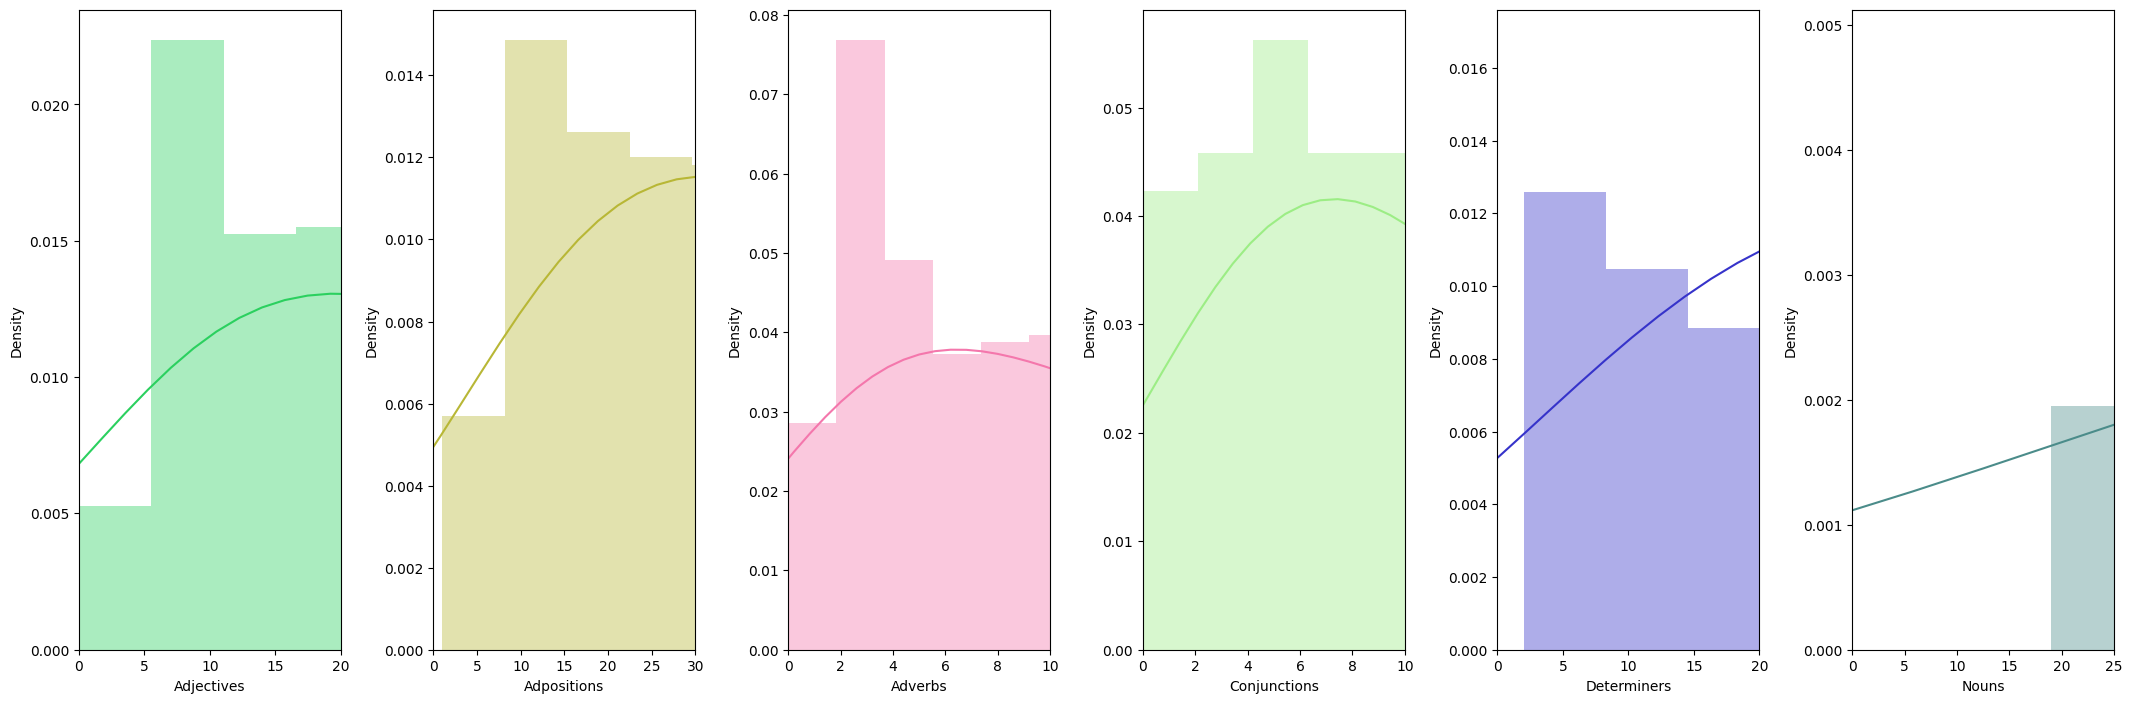

In [467]:
# Select the columns to plot: those related to pos taggings
plot_vars=np.array([['ADJ','ADP','ADV','CONJ','DET','NOUN']])
# Plot a histograms of the variables
labels_dict= {'ADJ':'Adjectives', 'ADP':'Adpositions',
               'ADV':'Adverbs', 'CONJ':'Conjunctions',
               'DET':'Determiners', 'NOUN':'Nouns'}
ratio = 0.7
plot_histograms(df_text, plot_vars, [20, 30, 10, 10, 20, 25], labels_dict, figsize=(15/ratio,5/ratio))

In [468]:
# # plot histograms of unknown words 'X' in text and summary with plot_histograms function
# plot_histograms(df_text, np.array([['.','X']]), [0.5], {'X':'Unknown words'}, figsize=(5/ratio,5/ratio))
# plot_histograms(df_summary, np.array([['.','X']]), [0.5], {'X':'Unknown words'}, figsize=(5/ratio,5/ratio))

### Most frequent terms and Wordclouds

A Wordcloud (or Tag cloud) is a visual representation of text data. It displays a list of words and the importance of each beeing shown with font size or color (the bigger the more frequent). This format is useful for quickly perceiving the most relevant terms on a document or set of documents. - Wikipedia

In [469]:
# # Join the different processed texts together.
# long_string = ','.join(list(cleaned_text.values))
# # Create a WordCloud object
# wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# # Generate a word cloud
# wordcloud.generate(long_string)
# # Visualize the word cloud
# wordcloud.to_image()